In [2]:
%load_ext autoreload
%autoreload 2
import keras
import pandas as pd
import numpy as np
from src.functions import get_features_and_targets, create_dataset, create_network, plot_data, predict_with_uncertainty, \
    check_gpus, create_train_val_datasets, load_stations_from_path, create_test_datasets

2023-11-10 08:45:03.899099: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 08:45:03.899136: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 08:45:03.900745: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 08:45:04.021898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
check_gpus()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


2023-11-10 08:45:08.850175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 08:45:08.877805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 08:45:08.878100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [20]:
TRAIN_PATH = '../data/labeled_daily/train'
TEST_PATH = '../data/labeled_daily/test'
SEQUENCE_LENGTH = 20
TARGET_START_INDEX = SEQUENCE_LENGTH - 1
FEATURE_COLUMNS = ['HS', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
TARGET_COLUMN = 'no_snow'
DATE_COLUMN = 'measure_date'
SPLIT_PERCENTAGE = 0.8
DATASET_BATCH_SIZE = 64
# DATASET_BATCH_SIZE = None

# Active learning
UNCERTAINTY_ITERATIONS = 5

# Model configuration
MODEL_ARCHITECTURE = "128(l)-64-8(d)-1"
MODEL_INPUT_SHAPE = (SEQUENCE_LENGTH, len(FEATURE_COLUMNS))
MODEL_DROPOUT_RATE = 0.5
MODEL_OPTIMIZER = 'adam'
MODEL_METRICS = ['accuracy']
MODEL_LOSS = 'binary_crossentropy'
MODEL_BATCH_SIZE = 64
MODEL_EPOCHS = 10

In [21]:
training_stations = load_stations_from_path(TRAIN_PATH)
testing_stations = load_stations_from_path(TEST_PATH)

In [22]:
train_dataset, val_dataset, mean, std = create_train_val_datasets(
    training_stations, SPLIT_PERCENTAGE, FEATURE_COLUMNS, TARGET_COLUMN, SEQUENCE_LENGTH, TARGET_START_INDEX, DATASET_BATCH_SIZE
)

In [26]:
test_datasets = create_test_datasets(
    testing_stations, FEATURE_COLUMNS, TARGET_COLUMN, SEQUENCE_LENGTH, TARGET_START_INDEX, DATASET_BATCH_SIZE, mean, std
)

In [24]:
network = create_network(MODEL_ARCHITECTURE, MODEL_INPUT_SHAPE)
model = keras.Sequential(network)
model.compile(
    optimizer=MODEL_OPTIMIZER,
    metrics=MODEL_METRICS,
    loss=MODEL_LOSS
)

history = model.fit(
    train_dataset,
    epochs=MODEL_EPOCHS,
    batch_size=MODEL_BATCH_SIZE,
    validation_data=val_dataset,
)

<class 'keras.src.layers.rnn.lstm.LSTM'> 128 <function tanh at 0x7f4efd95b7f0> True
<class 'src.backed_up.MonteCarloDropout'> 0.5
<class 'keras.src.layers.rnn.lstm.LSTM'> 64 <function tanh at 0x7f4efd95b7f0> False
<class 'src.backed_up.MonteCarloDropout'> 0.5
<class 'keras.src.layers.core.dense.Dense'> 8 <function relu at 0x7f4efd95b490>
<class 'keras.src.layers.core.dense.Dense'> 1 <function sigmoid at 0x7f4efd95b9a0>
Epoch 1/10


2023-11-10 08:59:32.054790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-10 08:59:33.773328: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4e341082d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-10 08:59:33.773348: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti with Max-Q Design, Compute Capability 6.1
2023-11-10 08:59:33.811979: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-10 08:59:33.992537: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1535/1535 [==============================] - 21s 10ms/step - loss: 0.1924 - accuracy: 0.9230 - val_loss: 0.1512 - val_accuracy: 0.9438
Epoch 2/10
1535/1535 [==============================] - 16s 10ms/step - loss: 0.1628 - accuracy: 0.9361 - val_loss: 0.1379 - val_accuracy: 0.9480
Epoch 3/10
1535/1535 [==============================] - 17s 11ms/step - loss: 0.1533 - accuracy: 0.9415 - val_loss: 0.1332 - val_accuracy: 0.9497
Epoch 4/10
1535/1535 [==============================] - 16s 10ms/step - loss: 0.1473 - accuracy: 0.9446 - val_loss: 0.1349 - val_accuracy: 0.9526
Epoch 5/10
1535/1535 [==============================] - 16s 11ms/step - loss: 0.1416 - accuracy: 0.9474 - val_loss: 0.1357 - val_accuracy: 0.9546
Epoch 6/10
1535/1535 [==============================] - 19s 12ms/step - loss: 0.1373 - accuracy: 0.9486 - val_loss: 0.1298 - val_accuracy: 0.9536
Epoch 7/10
1535/1535 [==============================] - 19s 12ms/step - loss: 0.1339 - accuracy: 0.9504 - val_loss: 0.1216 - val_accura

In [27]:
for dt in test_datasets:
    model.evaluate(dt)

174/174 [==============================] - 1s 5ms/step - loss: 0.2072 - accuracy: 0.9222


In [28]:
predictions = [model.predict(td).reshape((-1,)) > 0.5 for td in test_datasets]

174/174 [==============================] - 1s 4ms/step


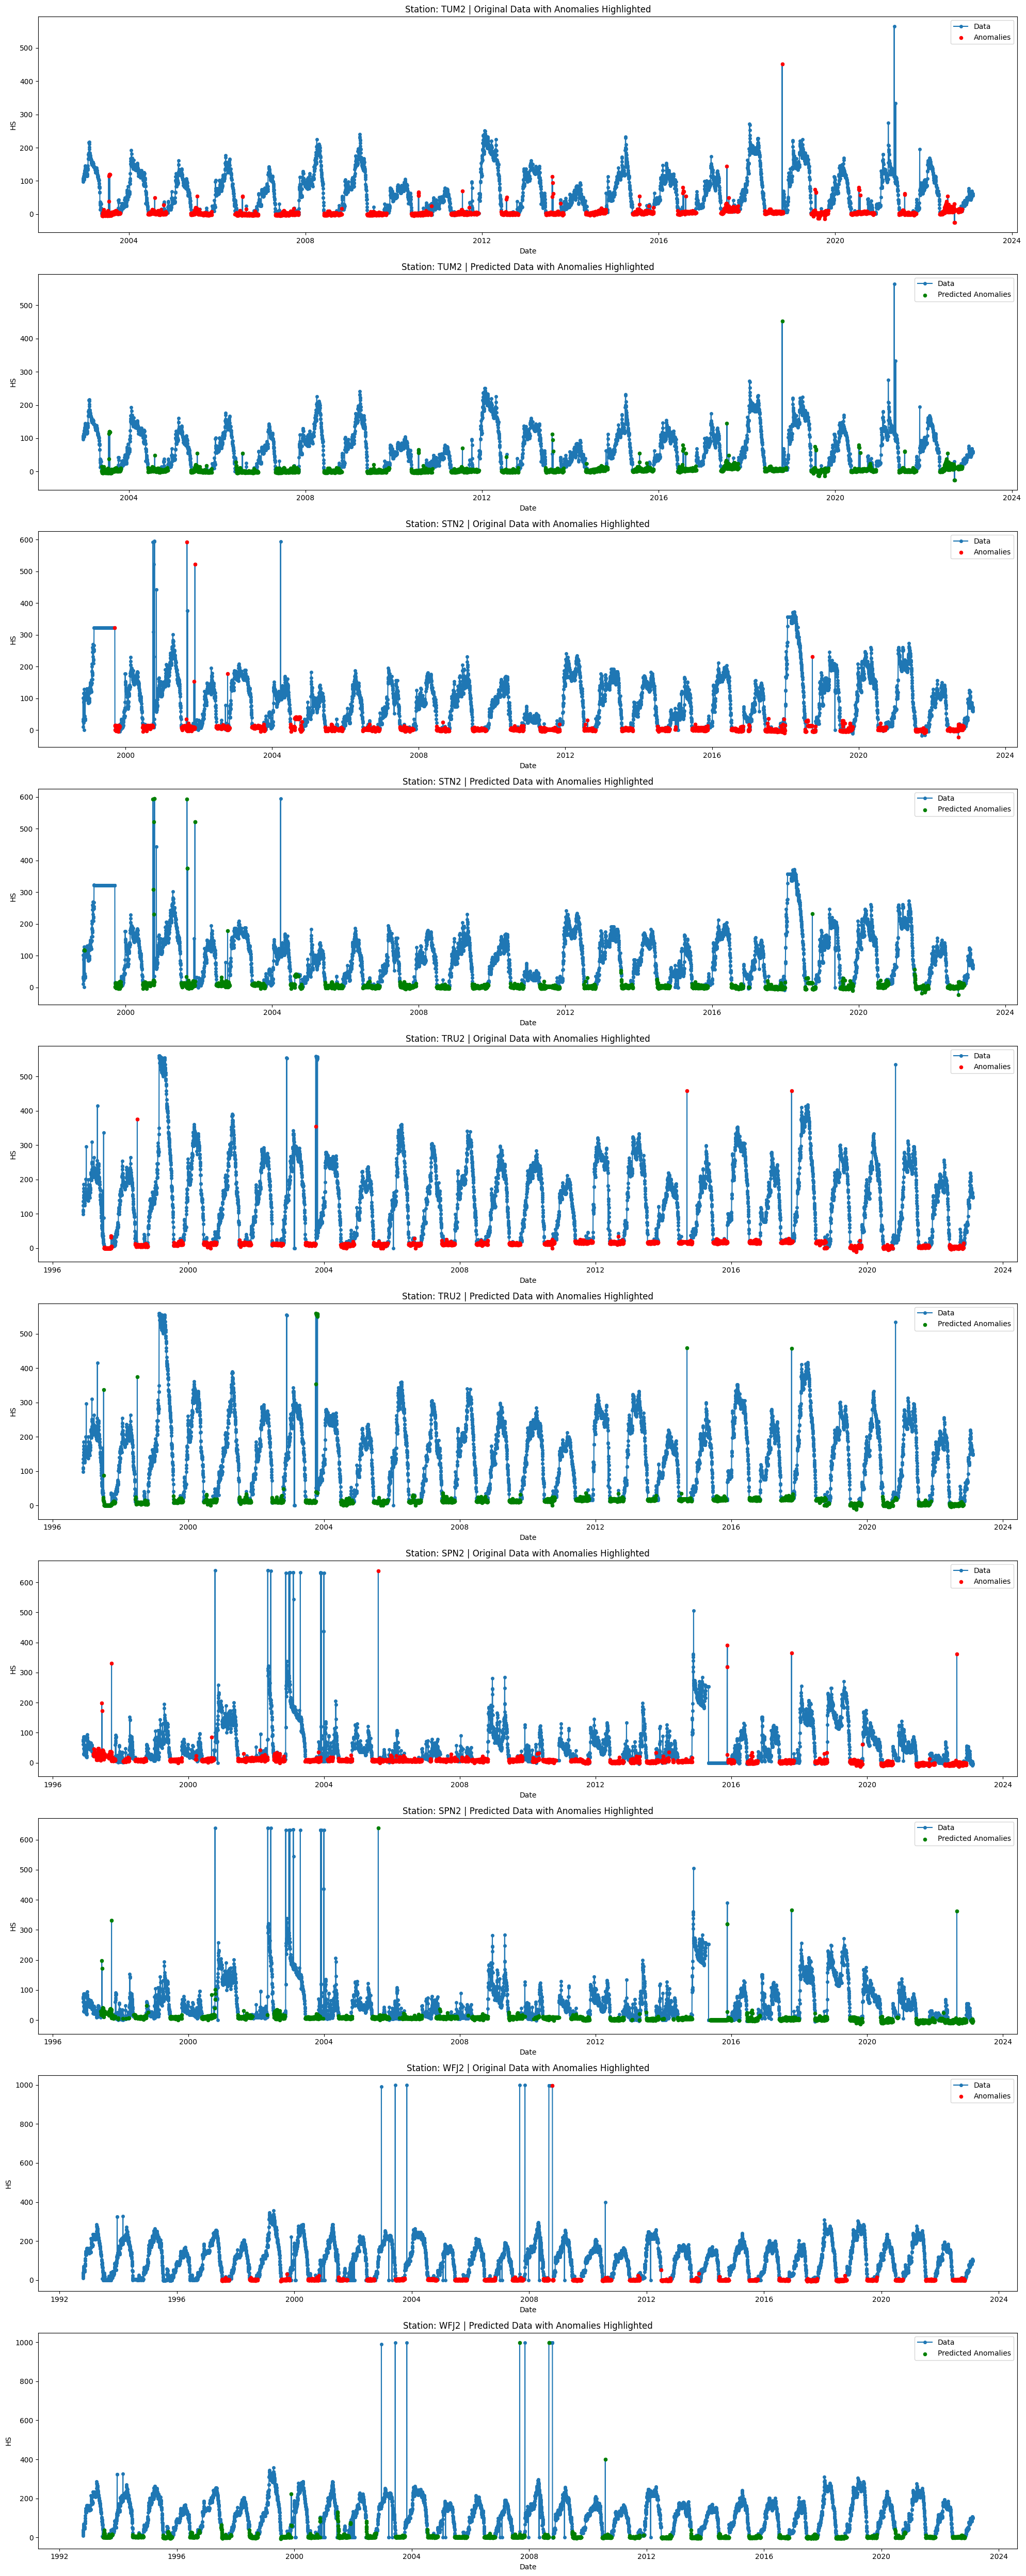

In [34]:
len(predictions[0]), len(testing_stations[0][TARGET_START_INDEX:])

plot_data(
    [test_station[TARGET_START_INDEX:] for test_station in testing_stations],
    predictions=predictions
)

In [ ]:
# uncertainties = [predict_with_uncertainty(model, create_dataset(station[0][0], station[0][1]), n_iter=20) for station in test_stations]
# accuracy = [model.evaluate(create_dataset(station[0][0], station[0][1]))[1] for station in test_stations]
# 
# print(np.corrcoef(uncertainties, accuracy))

In [ ]:
# arch = "128(l)-64-8(d)-15
arch = "128(l)-64-8(d)-1"
sequence_length = 30 # TODO: Make sequence length global
input_shape = (sequence_length, 5) # TODO: Replace with variable that contains number of features
epochs = 10
model_batch_size = 64

network = create_network(arch, input_shape)

model = keras.Sequential(network)
model.compile(
    optimizer='adam',
    metrics='accuracy',
    loss='binary_crossentropy'
)

group_split_num = 15
last_training_station = df['station_code'].unique()[:group_split_num]
active_learning_samples_index = df[df['station_code'] == last_training_station[-1]].index[-1] + 1

active_learning_df = df[:active_learning_samples_index]
out_of_sample_df = df[active_learning_samples_index:]

active_stations = np.random.choice(active_learning_df['station_code'].unique(), 1).tolist()
split_percentage = 0.8
summary = []

for i in range(group_split_num):
    print(f'====================================================')
    print(f'Active Learning Iteration #{i}')
    print(f'Current Training Stations: {active_stations}')
    current_iteration_train_df, current_iteration_val_df = pd.DataFrame(), pd.DataFrame()

    for station in active_stations:
        station_data = df[df['station_code'] == station]
        split_index = int(len(station_data) * split_percentage)

        current_iteration_train_df = pd.concat([current_iteration_train_df, station_data[:split_index]])
        current_iteration_val_df = pd.concat([current_iteration_val_df, station_data[split_index:]])

    current_iteration_df = pd.concat([current_iteration_train_df, current_iteration_val_df])
    split_index = len(current_iteration_train_df)
    
    print(f'Training samples: {len(current_iteration_train_df)}')
    print(f'Validation samples: {len(current_iteration_val_df)}')
    
    current_iteration_features, current_iteration_targets, current_iteration_mean, current_iteration_std = get_features_and_targets(current_iteration_df, split_index)
    
    current_iteration_train_dataset = create_dataset(current_iteration_features, current_iteration_targets, end_index=split_index, shuffle=True)
    current_iteration_val_dataset = create_dataset(current_iteration_features, current_iteration_targets, start_index=split_index, shuffle=True)
    
    history = model.fit(current_iteration_train_dataset, epochs=epochs, batch_size=model_batch_size, validation_data=current_iteration_val_dataset)

    out_of_sample_features, out_of_sample_targets, _, _ = get_features_and_targets(out_of_sample_df, mean=current_iteration_mean, std=current_iteration_std)
    out_of_sample_dataset = create_dataset(out_of_sample_features, out_of_sample_targets, shuffle=True)

    print(f'Evaluation model on out of sample data...')
    evaluation_results = model.evaluate(out_of_sample_dataset)

    inactive_stations_grouped = active_learning_df[~active_learning_df['station_code'].isin(active_stations)].groupby('station_code')
    uncertainties = {}
    most_uncertain_station_name = None
    
    if inactive_stations_grouped.ngroups != 0:
        print(f'Calculating uncertainty scores...')
        for name, group in inactive_stations_grouped:
            inactive_station_df = group.reset_index(drop=True)
            inactive_station_features, inactive_station_targets, _, _ = get_features_and_targets(inactive_station_df, scale=False)
            inactive_station_dataset = create_dataset(inactive_station_features, inactive_station_targets, shuffle=True)
            uncertainty_score = predict_with_uncertainty(model, inactive_station_dataset, n_iter=5)
            uncertainties[name] = uncertainty_score

        most_uncertain_station_name = max(uncertainties, key=uncertainties.get)

        print(f'Most uncertain {most_uncertain_station_name}')

    summary.append({
        'iteration': i,
        'active_learning_train': active_stations.copy(),
        'active_learning_predict': uncertainties.keys(),
        'evaluation_results': evaluation_results,
        'uncertainty_scores': uncertainties,
        'most_uncertain': most_uncertain_station_name
    })

    active_stations.append(most_uncertain_station_name)

In [ ]:
summary = pd.DataFrame(summary)
summary

In [ ]:
! mkdir '2023-11-02_12-00-00_active_learning_results'
# save results to txt
summary.to_csv('./2023-11-02_12-00-00_active_learning_results/summary.csv', index=False)
# save output to txt

In [ ]:
model.save('./2023-11-02_12-00-00_active_learning_results/model.keras')